<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Lab 3: k-NN Regression

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>


---



In [ ]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<div class="exercise">  <b>Question:</b> Load the data into a DataFrame called us_covid</div>

In [4]:
# %load knn_solns/q1.py
""" Load Data """
us_covid = pd.read_csv('data/us-states.csv')
us_covid.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53,Washington,1,0.14,0.0,0,0.0,0.0
1,2020-01-22,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
2,2020-01-23,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
3,2020-01-24,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
4,2020-01-24,USA-17,Illinois,1,0.14,0.0,0,0.0,0.0


<div class="exercise">  <b>Question:</b> Create a column called day where the column contains the day number. For example, 0 is the first date of data, 1 is the second, etc.</div>

In [8]:
pd.DataFrame(us_covid.date.unique()).reset_index()

,index,0
0,0,2020-01-21
1,1,2020-01-22
2,2,2020-01-23
3,3,2020-01-24
4,4,2020-01-25
...,...,...
578,578,2021-08-21
579,579,2021-08-22
580,580,2021-08-23
581,581,2021-08-24


In [6]:
# %load knn_solns/q2a.py
day_index = pd.DataFrame(us_covid.date.unique())
day_index = day_index.reset_index()
day_index.columns = ['day', 'date']
day_index.head()

,day,date
0,0,2020-01-21
1,1,2020-01-22
2,2,2020-01-23
3,3,2020-01-24
4,4,2020-01-25


In [10]:
# %load knn_solns/q2b.py
us_covid = us_covid.merge(day_index, on='date')
us_covid.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,day
0,2020-01-21,USA-53,Washington,1,0.14,0.0,0,0.0,0.0,0
1,2020-01-22,USA-53,Washington,0,0.14,0.0,0,0.0,0.0,1
2,2020-01-23,USA-53,Washington,0,0.14,0.0,0,0.0,0.0,2
3,2020-01-24,USA-53,Washington,0,0.14,0.0,0,0.0,0.0,3
4,2020-01-24,USA-17,Illinois,1,0.14,0.0,0,0.0,0.0,3


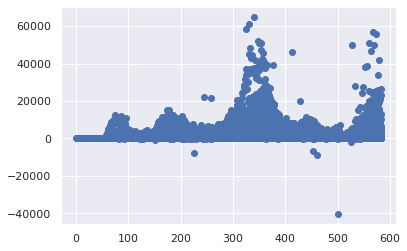

In [11]:
plt.scatter(us_covid.day, us_covid.cases)

<div class="exercise">  <b>Question:</b> Remove any rows where the number of cases is less than or equal to zero.</div>

In [14]:
(us_covid.cases <= 0).sum()

2719

In [15]:
# %load knn_solns/q3.py
us_covid = us_covid[us_covid.cases > 0]

In [16]:
us_covid.shape

(27050, 10)

<div class="exercise">  <b>Question:</b> Create a new DataFrame, called se_covid, which contains data from states in the South Eastern U.S. (South Carolina, North Carolina, Georgia, Florida, Tennessee, Mississippi, and Alabama)</div>

In [17]:
us_covid.state.isin(set('South Carolina'))

0        False
4        False
7        False
10       False
11       False
         ...  
29762    False
29763    False
29764    False
29765    False
29767    False
Name: state, Length: 27050, dtype: bool

In [19]:
# %load knn_solns/q4.py
south_east_states = set(['South Carolina', 'North Carolina', 
                         'Georgia', 'Florida', 'Tennessee', 
                         'Mississippi', 'Alabama'])

se_covid = us_covid[us_covid.state.isin(south_east_states)]

In [21]:
se_covid.shape

(3547, 10)

In [20]:
se_covid.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,day
250,2020-03-01,USA-12,Florida,2,0.29,0.0,0,0.0,0.0,40
264,2020-03-02,USA-13,Georgia,2,0.29,0.0,0,0.0,0.0,41
274,2020-03-03,USA-37,North Carolina,1,0.14,0.0,0,0.0,0.0,42
281,2020-03-03,USA-12,Florida,1,0.43,0.0,0,0.0,0.0,42
305,2020-03-05,USA-47,Tennessee,1,0.14,0.0,0,0.0,0.0,44


<div class="exercise">  <b>Question:</b> Split se_covid into training and test sets with an 70/30 split.</div>

In [23]:
# %load knn_solns/q5.py
""" Split into Test/Train sets """
# Random_state makes sure we get the same split each time this random process runs 
# (i.e., it takes out the randomness)
train_data, test_data = train_test_split(se_covid, test_size=0.3, random_state=42)

In [25]:
train_data.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,day
7768,2020-07-21,USA-01,Alabama,1467,1871.86,38.18,12,19.86,0.40,182
1874,2020-04-05,USA-12,Florida,805,1057.00,4.92,26,22.86,0.11,75
27779,2021-07-20,USA-12,Florida,24017,7740.43,36.04,27,30.14,0.14,546
18319,2021-01-29,USA-12,Florida,10976,10138.14,47.20,219,177.57,0.83,374
6644,2020-07-01,USA-28,Mississippi,652,639.43,21.49,9,10.14,0.34,162


<div class="exercise">  <b>Question:</b> Plot the training data</div>

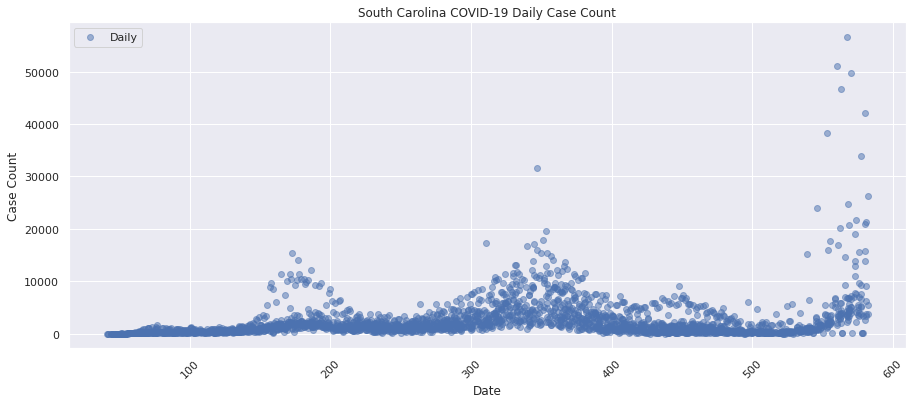

In [27]:
# %load knn_solns/q6.py
""" Visualize Training Data """
fig, ax = plt.subplots(1, 1, figsize=(15,6))

ax.scatter(train_data.day, train_data.cases, 
           label='Daily', alpha=0.5)
ax.set_title('South Carolina COVID-19 Daily Case Count')
ax.set_xlabel('Date')
ax.set_ylabel('Case Count')

ax.tick_params(axis='x', labelrotation=45)
ax.legend();

In [28]:
model = KNeighborsRegressor(n_neighbors=50)

In [30]:
model.fit(
    train_data[['day']], # Input needs to be a Pandas DataFrame or a Numpy array
    train_data[['cases']])

KNeighborsRegressor(n_neighbors=50)

In [33]:
train_data['day'].values

array([182,  75, 546, ..., 170, 575, 511])

<div class="exercise">  <b>Question:</b> Fit a dictionary of kNN Regression models where they dictionary key is the value of k and the value is the fitted kNN model with the corresponding value of k. Use the following values of k: 1, 10, 75, 250, 500, 750, 1000, and the number of examples in the training set.</div>

In [ ]:
knn1 = KNeighborsRegressor(n_neighbors=1)
knn10 = KNeighborsRegressor(n_neighbors=10)

In [ ]:
{1: KNeighborsRegressor(n_neighbors=1),
}

In [35]:
# %load knn_solns/q7.py
# define k values
k_values = [1, 10, 75, 250, 500, 750, 1000, train_data.shape[0]]

# build a dictionary KNN models
KNNModels = {k: KNeighborsRegressor(n_neighbors=k) for k in k_values}

# fit each KNN model
for k_value in KNNModels: 
    KNNModels[k_value].fit(train_data[['day']], train_data[['cases']])

<div class="exercise">  <b>Question:</b> Create two dictionaries containing the predictions on both the train and test datasets. Name these dictionaries knn_predicted_pickups_train and knn_predicted_pickups_test.</div>

In [37]:
model.predict(train_data[['day']])

array([[3411.96],
       [ 387.36],
       [2243.66],
       ...,
       [2982.28],
       [9689.22],
       [ 594.34]])

In [39]:
# %load knn_solns/q8.py
# Generate predictions
knn_predicted_pickups_train = {k: KNNModels[k].predict(train_data[['day']]) for k in KNNModels}
knn_predicted_pickups_test = {k: KNNModels[k].predict(test_data[['day']]) for k in KNNModels}

<div class="exercise">  <b>Question:</b> Plot the training data of each model, as well as the model predictions.</div>

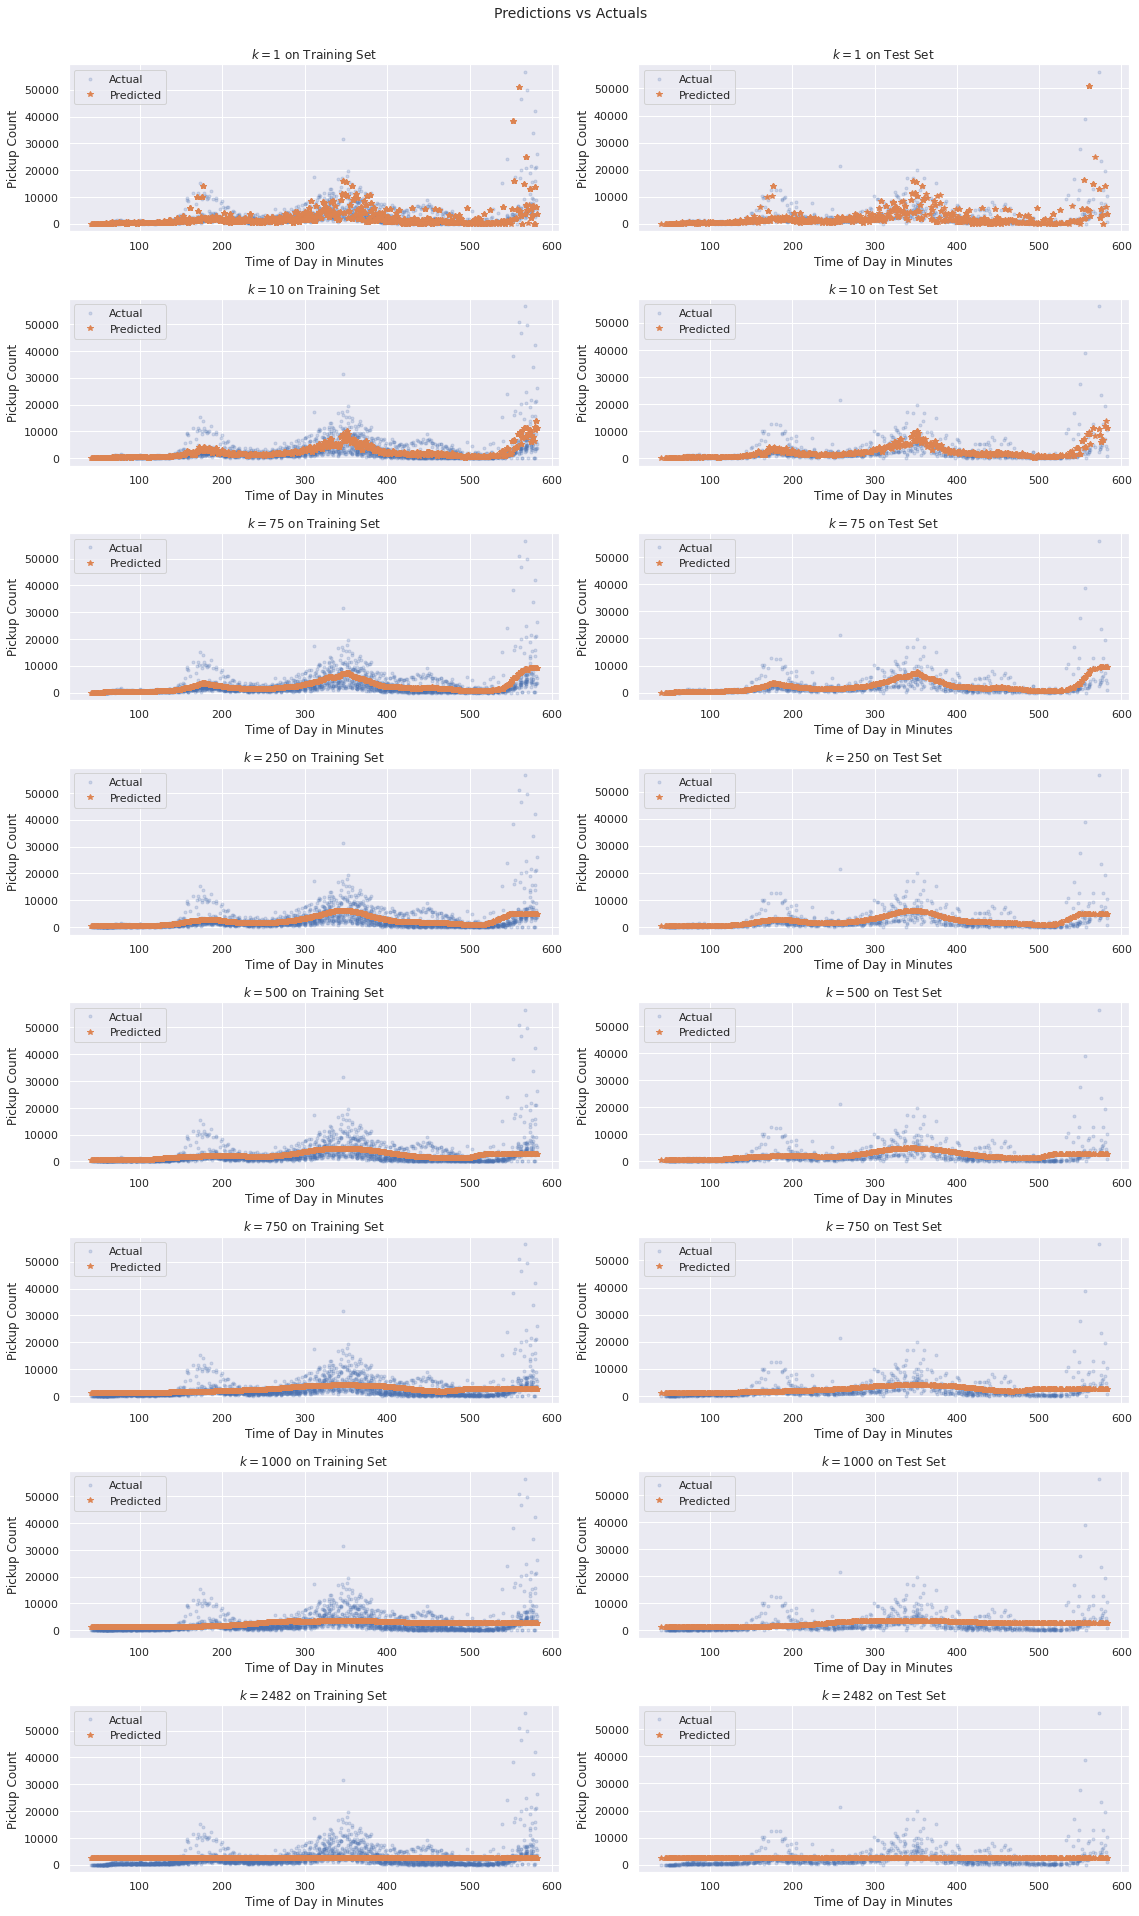

In [41]:
# %load knn_solns/q9.py
# Your code here

# Preferred to use a function if the process is identical and repeated with varying inputs
# Try to use functions in your homeworks to make things easier for yourself and more replicable

# Function to plot predicted vs actual for a given k and dataset
def plot_knn_prediction(ax, dataset, predictions, k, dataset_name= "Training"):
    
    # scatter plot actual
    ax.plot(dataset['day'], dataset['cases'], '.', alpha=0.2, label='Actual')
    
    # scatter plot predictions
    ax.plot(dataset['day'], predictions, '*',  label='Predicted')
    
    # Set labels
    ax.set_title("$k = {}$ on {} Set".format(str(k), dataset_name))
    ax.set_xlabel('Time of Day in Minutes')
    ax.set_ylabel('Pickup Count')
    ax.legend()

    
# Notice that nrows is set to the variable size. This makes the code more readable and adaptable
fig, axes = plt.subplots(nrows=len(k_values), ncols=2, figsize=(16,28))
fig.suptitle('Predictions vs Actuals', fontsize=14)
for i, k in enumerate(k_values):
    plot_knn_prediction(axes[i][0], train_data, knn_predicted_pickups_train[k], k, "Training")
    plot_knn_prediction(axes[i][1], test_data, knn_predicted_pickups_test[k], k, "Test")

fig.tight_layout(rect=[0,0.03,1,0.98])

<div class="exercise">  <b>Question:</b> What happens as k increases? What prediction do we get when k is equal to the number of training points? </div>

**Your answer here.**

<div class="exercise">  <b>Question:</b> Report the train and test R2 values for each model. </div>

In [43]:
# %load knn_solns/q11.py
""" Report your R2 values """

knn_r2_train = {k : r2_score(train_data[['cases']], knn_predicted_pickups_train[k]) for k in k_values}
knn_r2_test = { k : r2_score(test_data[['cases']], knn_predicted_pickups_test[k]) for k in k_values}

# This format makes the display much more readable
knn_r2_df = pd.DataFrame(data = {"k" : tuple(knn_r2_train.keys()), 
                                    "Train R^2" : tuple(knn_r2_train.values()), 
                                    "Test R^2" : tuple(knn_r2_test.values())})


knn_r2_df

,k,Train R^2,Test R^2
0,1,-0.185419,-0.665587
1,10,0.361004,0.238698
2,75,0.330913,0.294143
3,250,0.262942,0.265042
4,500,0.172775,0.175839
5,750,0.111181,0.109785
6,1000,0.075126,0.072380
7,2482,0.000000,-0.002281


<div class="exercise">  <b>Question:</b> Create a plot of the train/test R2 values as a function of k.</div>

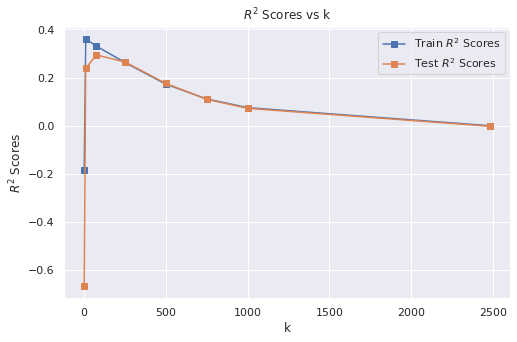

In [45]:
# %load knn_solns/q12.py
# Your code here

fig, axes = plt.subplots(figsize = (8,5))

axes.plot(knn_r2_df['k'], knn_r2_df['Train R^2'], 's-', label='Train $R^2$ Scores')
axes.plot(knn_r2_df['k'], knn_r2_df['Test R^2'], 's-', label='Test $R^2$ Scores')

axes.set_xlabel('k')
axes.set_ylabel('$R^2$ Scores')

# A generic title of this format (y vs x) is generally appropriate
axes.set_title("$R^2$ Scores vs k")

# Including a legend is very important
axes.legend();